# Using dask for large systems of financial models
## Basic Example

Petr Wolf, Dhivya Shankaranarayan

This notebook illustrates the concepts presented in "[Using dask for large systems of financial models](https://pydata.org/nyc2018/schedule/presentation/16/)" talk from [PyData NYC 2018](https://pydata.org/nyc2018).

Source location:
* [Notebook](https://github.com/PetrWolf/pydata_nyc_2018)
* [Slides](https://www.slideshare.net/PetrWolf1/using-dask-for-large-systems-of-financial-models)

## Installation
To run this notebook, you need Python 3.6, IPython, cytoolz dask and graphviz.

Use conda to install them all:

```
conda env create -p <target/env/location> --file environment.yaml
```

## Disclaimer
Note that this notebook serves only as an example to demonstrate the main idea of the presentation. 

Many details needed for a real implementation (e.g. checks, validation, multiple outputs) are deliberately not covered.

In [1]:
import functools
from cytoolz import dicttoolz
from IPython.display import display
import dask

## Defining functions
Definition of a @model decorator as a syntax extension for easier development and maintenance.

This decorator lets model developers annotate their functions with references to a global catalogue of all data, so that
automatic connections between models can be established.

In [2]:
def model(output, **inputs):
    """Decorator for annotating functions with input and output data labels.
    
    It wraps the underlying function and adds the following properties to the wrapper object:
        dsk - a dask graph representing the function's dependencies
        _repr_csv_ - to support visualization in Jupyter
    
    Args:
        inputs: data labels for input arguments
        output: data label for return value    
    """
    def model_decorator(f):
        @functools.wraps(f)
        def wrapper(*args, **kwds):
            return f(*args, **kwds)
        
        # Define the dask graph using Dask Custom Graph API notation.
        # Use None as the value of input nodes (so that they can be used in connections later)
        #
        # See Also
        # * http://docs.dask.org/en/latest/custom-graphs.html
        dsk = {
            output: (f, ) + tuple(inputs.values())
        }
        dsk.update({
            key: None for key in inputs.values()
        })
        wrapper.dsk = dsk
        
        # Add _repr_svg_ for visualization in Jupyter
        #
        # See Also:
        # * http://docs.dask.org/en/latest/graphviz.html
        # * https://ipython.readthedocs.io/en/stable/config/integrating.html
        wrapper._repr_svg_ = lambda : display(dask.visualize(dsk, rankdir='LR'))
        return wrapper
    
    return model_decorator

Now let's use `@model` in a simple example.

Both 'FOO' and 'BAR' are assummed to be globally defined data labels with a well-defined meaning, type and unit.

In [3]:
@model(foo='FOO', output='BAR')
def my_model(foo):
    """A sample model.
    Computes the value of 'FOO' based on 'BAR'.
    
    Args:
        foo: value of 'FOO'
    
    Returns:
        value of 'BAR'
    """
    return foo + 1

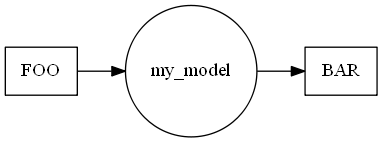

<function __main__.my_model(foo)>

In [4]:
my_model

Let's also inspect the dask graph corresponding to this function

In [5]:
my_model.dsk

{'BAR': (<function __main__.my_model(foo)>, 'FOO'), 'FOO': None}

## Merging graphs

The above concept becomes useful when merging multiple functions together into larger dependency graphs or evolving components within existing graphs.

To this end, we define a `join_graphs` function for merging two dask graphs

In [6]:
def join_graphs(a, b):
    """Operation to join two dask graphs.
    Where an output of one graphs matches an input to the other, a connection is created.
    If both graphs declare the same output, an exception is raised.
    
    Args:
        a, b: dask graphs to join
    
    Returns:
        new dask graph, created from `a` and `b`
    
    Raises:
        RuntimeError: if both graph define the same output
    """    
    return dicttoolz.merge_with(merge_dask_values, a, b)

In [7]:
def merge_dask_values(outputs):
    """Perform a merge of dask graph values"""
    producers = list(filter(None, outputs))
    if len(producers) == 0:
        return None
    elif len(producers) == 1:
        return producers[0] 
    else:
        raise RuntimeError('Conflict among producers') 

Now, let's add a second function, consuming 'BAR' and computing 'BAZ' from it

In [8]:
@model(bar='BAR', output='BAZ')
def another_model(bar):
    """Another sample model
    
    Args:
        bar: value of 'BAR'
        
    Returns:
        value of 'BAZ'
    """
    return bar * 2

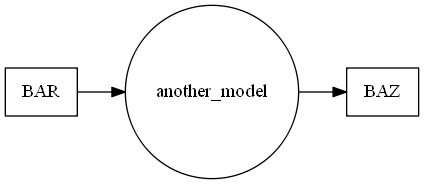

<function __main__.another_model(bar)>

In [9]:
another_model

By joining the two, we get a dask graph with three keys, one of which is an input

In [10]:
join_graphs(my_model.dsk, another_model.dsk)

{'BAR': (<function __main__.my_model(foo)>, 'FOO'),
 'FOO': None,
 'BAZ': (<function __main__.another_model(bar)>, 'BAR')}

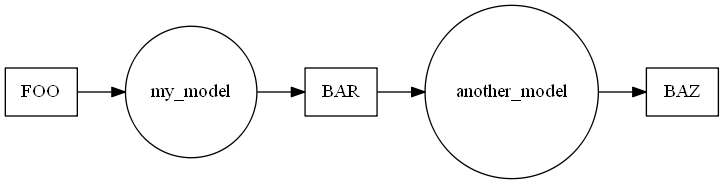

In [11]:
dask.visualize(join_graphs(my_model.dsk, another_model.dsk), rankdir='LR')

## Adding data
So far, the graph is entirely "abstract" and does not contain any actual values.
In order to use it for a computation, we must "initialize" the input nodes with actual values from a given context.

To that end, we add the concept of a "loader" function,

In [12]:
def add_loader(dsk, loader):
    """Connects a loader function call to each input node in the graph.
    
    A `loader` is a callable taking a data label and returning its value.
    
    Args:
        dsk: a dsk graph, where input nodes have value None
        loader: a function responsible for loading and returning a value for a given key
    
    Returns:
        a new dask graph with all "free" inputs connected to the loader function
    """
    return {key: value if value else (functools.partial(loader, key), ) 
            for key,value in dsk.items()}

In [13]:
def my_loader(key):
    """Sample loader function.
    
    In this example, we only expect to load the value of foo.
    A "real" loader might read files, access a database or a service to retrieve the value of a given key
    """
    assert key == 'FOO' 
    return 42

In [14]:
final_graph = add_loader(join_graphs(my_model.dsk, another_model.dsk), my_loader)

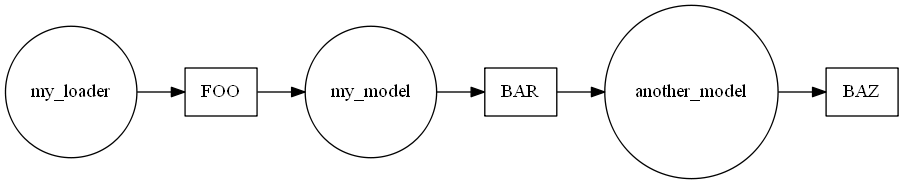

In [15]:
dask.visualize(final_graph, rankdir='LR')

## Execution
When a graph has no "free" input nodes, it can be executed

In [16]:
dask.get(final_graph, 'BAZ')  # expecting (42 + 1) * 2 = 86

86

## Summary
Clearly, such a trivial example hardly requires automated graph creation.
But the same principle can easily scale up to graphs of 100s or 1000s of functions, developed and tested individually and independently, while leveraging all the parallel execution and caching goodness of `dask`.

Example graph:

![example](dot-1024.png)